In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,LSTM, Reshape
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import glob
import random

In [2]:
x = []
y = []
for gambar in glob.glob("dataset_out/train/bukan_daun/*.jpg"):
  x.append(cv2.imread(gambar))
  y.append(0)
for gambar in glob.glob("dataset_out/train/daun_bercak/*.jpg"):
  x.append(cv2.imread(gambar))
  y.append(1)
for gambar in glob.glob("dataset_out/train/daun_berlubang/*.jpg"):
  x.append(cv2.imread(gambar))
  y.append(2)
for gambar in glob.glob("dataset_out/train/daun_busuk/*.jpg"):
  x.append(cv2.imread(gambar))
  y.append(3)
for gambar in glob.glob("dataset_out/train/daun_sehat/*.jpg"):
  x.append(cv2.imread(gambar))
  y.append(4)
    
z = list(zip(x,y))
random.shuffle(z)
x, y = zip(*z)
x = np.asarray(x)
y = np.asarray(y)

In [3]:

from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras import layers, models

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False


flatten_layer = layers.Flatten()
reshape_layer = layers.Reshape((32768,1))
lstm_layer_1 = layers.LSTM(25)
prediction_layer = layers.Dense(5, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    reshape_layer,
    lstm_layer_1,
    prediction_layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 32768, 1)          0         
                                                                 
 lstm (LSTM)                 (None, 25)                2700      
                                                                 
 dense (Dense)               (None, 5)                 130       
                                                                 
Total params: 23,590,542
Trainable params: 2,830
Non-trainable params: 23,587,712
_________________________________________________________________


In [5]:
history = model.fit(x, y, batch_size=5, epochs=30, validation_split=0.1)

Epoch 1/30
864/864 [==============================] - 2559s 3s/step - loss: 1.5636 - accuracy: 0.2720 - val_loss: 1.5193 - val_accuracy: 0.2958
Epoch 2/30
864/864 [==============================] - 2572s 3s/step - loss: 1.5331 - accuracy: 0.2933 - val_loss: 1.5175 - val_accuracy: 0.3229
Epoch 3/30
864/864 [==============================] - 2492s 3s/step - loss: 1.5202 - accuracy: 0.3035 - val_loss: 1.5231 - val_accuracy: 0.2958
Epoch 4/30
864/864 [==============================] - 2248s 3s/step - loss: 1.5133 - accuracy: 0.3146 - val_loss: 1.4986 - val_accuracy: 0.3125
Epoch 5/30
864/864 [==============================] - 2174s 3s/step - loss: 1.5043 - accuracy: 0.3127 - val_loss: 1.5077 - val_accuracy: 0.3208
Epoch 6/30
864/864 [==============================] - 2056s 2s/step - loss: 1.5008 - accuracy: 0.3123 - val_loss: 1.5211 - val_accuracy: 0.3021
Epoch 7/30
864/864 [==============================] - 2071s 2s/step - loss: 1.4909 - accuracy: 0.3278 - val_loss: 1.5096 - val_accuracy:

Text(0.5, 1.0, 'Training and validation loss')

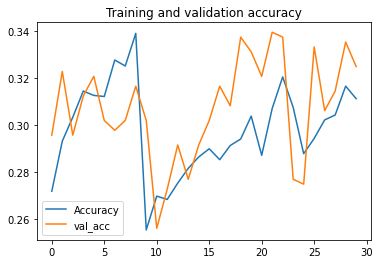

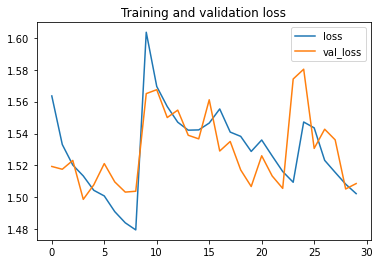

In [6]:
from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(["Accuracy","val_acc"])
plt.title('Training and validation accuracy')
 
plt.figure()
 
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(["loss","val_loss"])
plt.title('Training and validation loss')

In [7]:
model.save("lstm_resnet50_25.h5")

In [8]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

test_set = tf.keras.preprocessing.image_dataset_from_directory('dataset_out/val',
                                            image_size=(128, 128),
                                            batch_size=5,
                                            label_mode='categorical')

Found 600 files belonging to 5 classes.


In [9]:
def pred(model):
    y_val = []
    y_val_pred = []
    for images, targets in test_set:
        for image, target in zip(images, targets):
            img_array = image.numpy().astype("uint8")
            prediction = model.predict(np.array([img_array]))
            y_val_pred.append(np.argmax(prediction))
            y_val.append(np.argmax(target))
            
    return y_val, y_val_pred

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, accuracy_score, plot_confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

y_val, y_val_pred = pred(model)

print('Confusion Matrix :')


1/1 [==============================] - 1s 719ms/step


1/1 [==============================] - 1s 641ms/step
Confusion Matrix :


In [11]:
accuracy_score(y_val, y_val_pred)

0.31666666666666665

In [14]:
print('Classification Report :')
print(classification_report(y_val, y_val_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.40      0.29      0.34       120
           1       0.44      0.14      0.21       120
           2       0.24      0.15      0.18       120
           3       0.26      0.46      0.33       120
           4       0.35      0.54      0.42       120

    accuracy                           0.32       600
   macro avg       0.34      0.32      0.30       600
weighted avg       0.34      0.32      0.30       600



In [12]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                           title='Confusion matrix',
                           cmap=plt.cm.Purples):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
     plt.imshow(cm, interpolation='nearest', cmap=cmap)
     plt.title(title)
     plt.colorbar()
     tick_marks = np.arange(len(classes))
     plt.xticks(tick_marks, classes, rotation=45)
     plt.yticks(tick_marks, classes)

     if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
     else:
         print('Confusion matrix, without normalization')

     print(cm)

     thresh = cm.max() / 2.
     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

     plt.tight_layout()
     plt.ylabel('Actual label')
     plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35  2 15 54 14]
 [12 17 16 35 40]
 [10  5 18 48 39]
 [17  3 16 55 29]
 [13 12 11 19 65]]


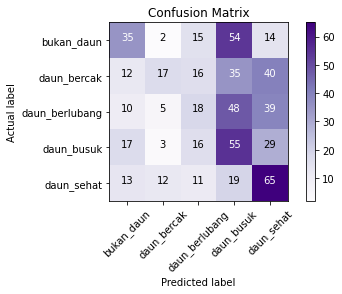

In [13]:
import itertools
cm = confusion_matrix(y_val, y_val_pred)
cm_plot_labels = ['bukan_daun','daun_bercak','daun_berlubang','daun_busuk','daun_sehat']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')